# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [ ]:
import subprocess
print(subprocess.run(["pip install tqdm"], stdout=subprocess.PIPE, shell=True).stdout.decode())

data_dir = './input'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [21:13<00:00, 47.1File/s]  


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

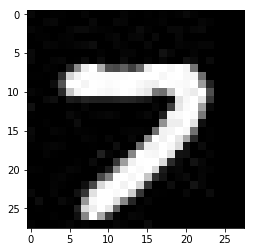

In [5]:
show_n_images = 1

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

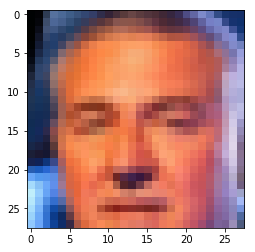

In [6]:
show_n_images = 1

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    z_inputs = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learn_rate = tf.placeholder(tf.float32, [], name='learning_rate')
    
    return real_inputs, z_inputs, learn_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [10]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer (images) is 28x28x3 so we have to apply a Convolution layer that turns it into 14x14x32
        conv1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * conv1, conv1)
        
        # Next step is to apply another Convolution layer to get 7x7x64
        # We also apply Batch Normalization on x2
        conv2 = tf.layers.conv2d(conv1, 64, 5, strides=2, padding='same')
        batch_norm = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(alpha * conv2, conv2)
        
        # Finally, we flatten the Output of 7x7x64
        flatten = tf.reshape(relu2, (-1, 7*7*64))
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)
    
    return output, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [11]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # Fully Connected layer
        fcl = tf.layers.dense(z, 7*7*64)
        
        # Reshape to have an Input layer z of 7*7*64 and apply Batch Normalization
        x = tf.reshape(fcl, (-1,7,7,64))
        batch_norm1 = tf.layers.batch_normalization(x, training=is_train)
        relu1 = tf.maximum(alpha * x, x)
        
        # Apply Convolution to enlarge the Input layer to 14x14x32
        conv1 = tf.layers.conv2d_transpose(x, 32, 5, strides=2, padding='same')
        batch_norm2 = tf.layers.batch_normalization(conv1, training=is_train)
        relu2 = tf.maximum(alpha * conv1, conv1)
        
        # Apply another Convolution to generate the final Output layer of 28x28x3
        logits = tf.layers.conv2d_transpose(conv1, out_channel_dim, 5, strides=2, padding='same')
        
        # Finally, apply tf.tanh() to create output
        output = tf.tanh(logits)
    
        return output    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [12]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize using tf.train.AdamOptimizer()
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [14]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
   # Set all variables to store the model functions
    _ , img_w, img_h, img_d = data_shape
    real_input, z_input, lr = model_inputs(img_w, img_h, img_d, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, img_d)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # Set additional params
    steps = 0
    losses = []
    print_every = 10
    show_every = 100
    figsize=(5,5)
    
    # Run tf.Session()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2
                steps += 1
                
                # Generate sample random noise for Generator
                sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run Optimizers
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: sample_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={z_input: sample_z, lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({z_input: sample_z, real_input: batch_images})
                    train_loss_g = g_loss.eval({z_input: sample_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 25, z_input, img_d, data_image_mode)
                    
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7404... Generator Loss: 0.6642
Epoch 1/2... Discriminator Loss: 0.6571... Generator Loss: 0.8689
Epoch 1/2... Discriminator Loss: 0.5735... Generator Loss: 1.6174
Epoch 1/2... Discriminator Loss: 0.6352... Generator Loss: 1.4089
Epoch 1/2... Discriminator Loss: 1.0061... Generator Loss: 1.1147
Epoch 1/2... Discriminator Loss: 1.3683... Generator Loss: 0.4215
Epoch 1/2... Discriminator Loss: 1.1111... Generator Loss: 0.8451
Epoch 1/2... Discriminator Loss: 1.2556... Generator Loss: 0.5894
Epoch 1/2... Discriminator Loss: 1.1991... Generator Loss: 0.8460
Epoch 1/2... Discriminator Loss: 1.0902... Generator Loss: 0.8854


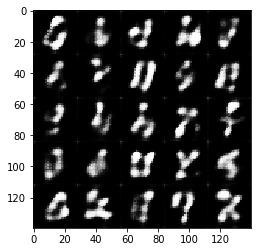

Epoch 1/2... Discriminator Loss: 1.2080... Generator Loss: 0.6642
Epoch 1/2... Discriminator Loss: 1.2348... Generator Loss: 0.6139
Epoch 1/2... Discriminator Loss: 1.1770... Generator Loss: 0.7629
Epoch 1/2... Discriminator Loss: 1.3253... Generator Loss: 0.8319
Epoch 1/2... Discriminator Loss: 1.1092... Generator Loss: 0.8010
Epoch 1/2... Discriminator Loss: 1.2070... Generator Loss: 0.7934
Epoch 1/2... Discriminator Loss: 1.2101... Generator Loss: 0.8648
Epoch 1/2... Discriminator Loss: 1.2261... Generator Loss: 0.7526
Epoch 1/2... Discriminator Loss: 1.3330... Generator Loss: 0.5394
Epoch 1/2... Discriminator Loss: 1.1650... Generator Loss: 0.7721


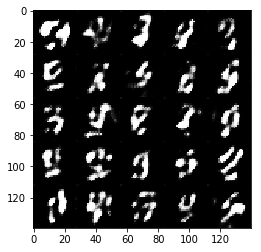

Epoch 1/2... Discriminator Loss: 1.2763... Generator Loss: 0.6694
Epoch 1/2... Discriminator Loss: 1.3057... Generator Loss: 0.7349
Epoch 1/2... Discriminator Loss: 1.2005... Generator Loss: 0.7845
Epoch 1/2... Discriminator Loss: 1.1793... Generator Loss: 0.8798
Epoch 1/2... Discriminator Loss: 1.3041... Generator Loss: 0.6537
Epoch 1/2... Discriminator Loss: 1.3059... Generator Loss: 0.8343
Epoch 1/2... Discriminator Loss: 1.2896... Generator Loss: 0.7120
Epoch 1/2... Discriminator Loss: 1.3686... Generator Loss: 0.6446
Epoch 1/2... Discriminator Loss: 1.2343... Generator Loss: 0.8567
Epoch 1/2... Discriminator Loss: 1.2453... Generator Loss: 0.7906


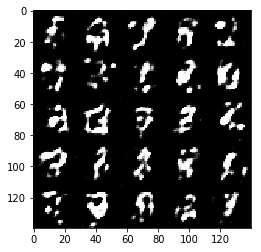

Epoch 1/2... Discriminator Loss: 1.3653... Generator Loss: 0.7597
Epoch 1/2... Discriminator Loss: 1.2605... Generator Loss: 0.7463
Epoch 1/2... Discriminator Loss: 1.2838... Generator Loss: 0.6778
Epoch 1/2... Discriminator Loss: 1.3303... Generator Loss: 0.6020
Epoch 1/2... Discriminator Loss: 1.2258... Generator Loss: 0.8110
Epoch 1/2... Discriminator Loss: 1.4370... Generator Loss: 1.2801
Epoch 1/2... Discriminator Loss: 1.3141... Generator Loss: 0.7247
Epoch 1/2... Discriminator Loss: 1.1841... Generator Loss: 0.8840
Epoch 1/2... Discriminator Loss: 1.1693... Generator Loss: 0.8661
Epoch 1/2... Discriminator Loss: 1.3066... Generator Loss: 0.7814


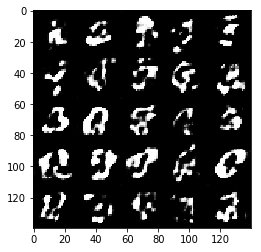

Epoch 1/2... Discriminator Loss: 1.2734... Generator Loss: 0.8065
Epoch 1/2... Discriminator Loss: 1.1961... Generator Loss: 0.7719
Epoch 1/2... Discriminator Loss: 1.3322... Generator Loss: 0.6912
Epoch 1/2... Discriminator Loss: 1.2104... Generator Loss: 0.7906
Epoch 1/2... Discriminator Loss: 1.1771... Generator Loss: 0.7969
Epoch 1/2... Discriminator Loss: 1.2180... Generator Loss: 0.7413
Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 0.9822
Epoch 1/2... Discriminator Loss: 1.1964... Generator Loss: 0.7351
Epoch 1/2... Discriminator Loss: 1.3296... Generator Loss: 1.2851
Epoch 1/2... Discriminator Loss: 1.1678... Generator Loss: 0.7715


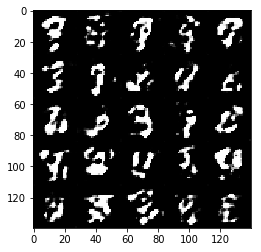

Epoch 1/2... Discriminator Loss: 1.0738... Generator Loss: 0.7513
Epoch 1/2... Discriminator Loss: 1.1700... Generator Loss: 0.7002
Epoch 1/2... Discriminator Loss: 1.1768... Generator Loss: 0.5953
Epoch 1/2... Discriminator Loss: 1.0310... Generator Loss: 0.9302
Epoch 1/2... Discriminator Loss: 1.1931... Generator Loss: 0.9174
Epoch 1/2... Discriminator Loss: 1.2196... Generator Loss: 0.6523
Epoch 1/2... Discriminator Loss: 1.0560... Generator Loss: 0.8928
Epoch 1/2... Discriminator Loss: 1.1068... Generator Loss: 0.9429
Epoch 1/2... Discriminator Loss: 1.1336... Generator Loss: 0.8099
Epoch 1/2... Discriminator Loss: 0.9838... Generator Loss: 0.7699


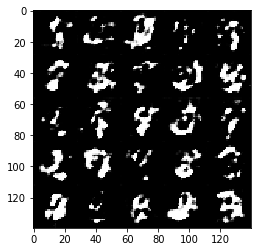

Epoch 1/2... Discriminator Loss: 1.2185... Generator Loss: 0.6007
Epoch 1/2... Discriminator Loss: 0.9969... Generator Loss: 0.8934
Epoch 1/2... Discriminator Loss: 1.0055... Generator Loss: 0.8596
Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 1.1736
Epoch 1/2... Discriminator Loss: 1.0470... Generator Loss: 0.7739
Epoch 1/2... Discriminator Loss: 1.0454... Generator Loss: 0.8719
Epoch 1/2... Discriminator Loss: 0.9633... Generator Loss: 1.1513
Epoch 1/2... Discriminator Loss: 0.9427... Generator Loss: 1.1865
Epoch 1/2... Discriminator Loss: 1.0346... Generator Loss: 1.2545
Epoch 1/2... Discriminator Loss: 1.0428... Generator Loss: 0.9177


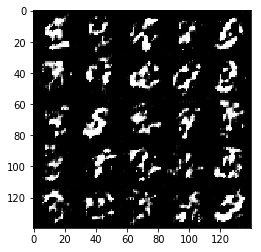

Epoch 1/2... Discriminator Loss: 0.8742... Generator Loss: 0.9867
Epoch 1/2... Discriminator Loss: 1.1558... Generator Loss: 1.6509
Epoch 1/2... Discriminator Loss: 1.0658... Generator Loss: 0.8764
Epoch 1/2... Discriminator Loss: 0.9022... Generator Loss: 0.8772
Epoch 1/2... Discriminator Loss: 1.0056... Generator Loss: 0.7299
Epoch 1/2... Discriminator Loss: 0.9392... Generator Loss: 1.1585
Epoch 1/2... Discriminator Loss: 0.8167... Generator Loss: 1.0767
Epoch 1/2... Discriminator Loss: 1.3184... Generator Loss: 0.4498
Epoch 1/2... Discriminator Loss: 1.0542... Generator Loss: 0.8527
Epoch 1/2... Discriminator Loss: 0.9443... Generator Loss: 1.2833


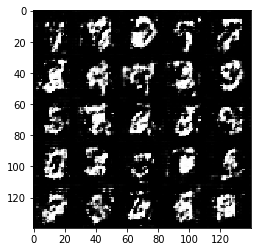

Epoch 1/2... Discriminator Loss: 0.9289... Generator Loss: 1.3258
Epoch 1/2... Discriminator Loss: 1.0915... Generator Loss: 0.9355
Epoch 1/2... Discriminator Loss: 0.8439... Generator Loss: 0.9675
Epoch 1/2... Discriminator Loss: 1.0877... Generator Loss: 0.6507
Epoch 1/2... Discriminator Loss: 0.9287... Generator Loss: 0.8323
Epoch 1/2... Discriminator Loss: 1.3547... Generator Loss: 0.3849
Epoch 1/2... Discriminator Loss: 0.8605... Generator Loss: 1.1242
Epoch 1/2... Discriminator Loss: 1.0659... Generator Loss: 1.6428
Epoch 1/2... Discriminator Loss: 0.8312... Generator Loss: 1.2280
Epoch 1/2... Discriminator Loss: 0.9641... Generator Loss: 0.9187


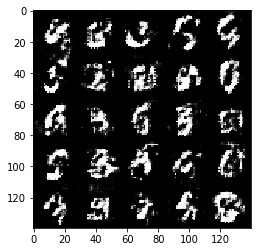

Epoch 1/2... Discriminator Loss: 0.8047... Generator Loss: 1.2669
Epoch 1/2... Discriminator Loss: 0.8646... Generator Loss: 1.5732
Epoch 1/2... Discriminator Loss: 0.8063... Generator Loss: 1.1334
Epoch 2/2... Discriminator Loss: 0.7157... Generator Loss: 1.1280
Epoch 2/2... Discriminator Loss: 0.8027... Generator Loss: 1.0673
Epoch 2/2... Discriminator Loss: 0.8848... Generator Loss: 1.9189
Epoch 2/2... Discriminator Loss: 0.8479... Generator Loss: 1.0160
Epoch 2/2... Discriminator Loss: 0.7028... Generator Loss: 1.0407
Epoch 2/2... Discriminator Loss: 0.7287... Generator Loss: 1.3062
Epoch 2/2... Discriminator Loss: 0.7674... Generator Loss: 1.7034


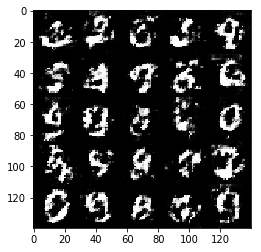

Epoch 2/2... Discriminator Loss: 0.6978... Generator Loss: 1.2570
Epoch 2/2... Discriminator Loss: 0.7552... Generator Loss: 1.2370
Epoch 2/2... Discriminator Loss: 0.6871... Generator Loss: 1.2915
Epoch 2/2... Discriminator Loss: 0.7007... Generator Loss: 1.2463
Epoch 2/2... Discriminator Loss: 0.7112... Generator Loss: 1.0538
Epoch 2/2... Discriminator Loss: 0.7077... Generator Loss: 1.6551
Epoch 2/2... Discriminator Loss: 0.7386... Generator Loss: 1.0399
Epoch 2/2... Discriminator Loss: 0.6231... Generator Loss: 1.7317
Epoch 2/2... Discriminator Loss: 0.6715... Generator Loss: 1.2607
Epoch 2/2... Discriminator Loss: 0.6744... Generator Loss: 0.9603


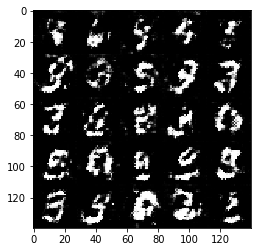

Epoch 2/2... Discriminator Loss: 0.5511... Generator Loss: 1.8417
Epoch 2/2... Discriminator Loss: 0.5547... Generator Loss: 1.4165
Epoch 2/2... Discriminator Loss: 0.6804... Generator Loss: 1.3332
Epoch 2/2... Discriminator Loss: 0.6492... Generator Loss: 1.1217
Epoch 2/2... Discriminator Loss: 0.5364... Generator Loss: 1.6688
Epoch 2/2... Discriminator Loss: 0.5284... Generator Loss: 1.9898
Epoch 2/2... Discriminator Loss: 0.5808... Generator Loss: 1.2882
Epoch 2/2... Discriminator Loss: 0.5285... Generator Loss: 1.9091
Epoch 2/2... Discriminator Loss: 0.8156... Generator Loss: 0.8659
Epoch 2/2... Discriminator Loss: 0.5472... Generator Loss: 1.7418


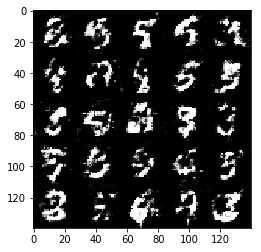

Epoch 2/2... Discriminator Loss: 0.5245... Generator Loss: 1.3362
Epoch 2/2... Discriminator Loss: 0.5824... Generator Loss: 1.2069
Epoch 2/2... Discriminator Loss: 0.5224... Generator Loss: 1.4859
Epoch 2/2... Discriminator Loss: 0.5158... Generator Loss: 1.6168
Epoch 2/2... Discriminator Loss: 0.5098... Generator Loss: 1.9684
Epoch 2/2... Discriminator Loss: 0.5682... Generator Loss: 1.8956
Epoch 2/2... Discriminator Loss: 0.4916... Generator Loss: 1.7537
Epoch 2/2... Discriminator Loss: 0.6054... Generator Loss: 2.0485
Epoch 2/2... Discriminator Loss: 0.4579... Generator Loss: 1.5296
Epoch 2/2... Discriminator Loss: 0.6817... Generator Loss: 1.0535


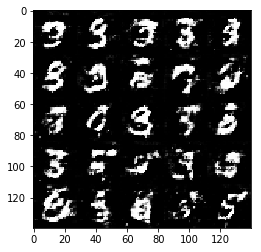

Epoch 2/2... Discriminator Loss: 0.5495... Generator Loss: 2.4791
Epoch 2/2... Discriminator Loss: 0.4137... Generator Loss: 1.8580
Epoch 2/2... Discriminator Loss: 0.4060... Generator Loss: 1.8888
Epoch 2/2... Discriminator Loss: 0.5300... Generator Loss: 1.5100
Epoch 2/2... Discriminator Loss: 0.4173... Generator Loss: 2.4331
Epoch 2/2... Discriminator Loss: 0.5475... Generator Loss: 1.2888
Epoch 2/2... Discriminator Loss: 0.5291... Generator Loss: 1.6224
Epoch 2/2... Discriminator Loss: 0.4573... Generator Loss: 1.7741
Epoch 2/2... Discriminator Loss: 0.4654... Generator Loss: 1.9955
Epoch 2/2... Discriminator Loss: 0.5538... Generator Loss: 1.3211


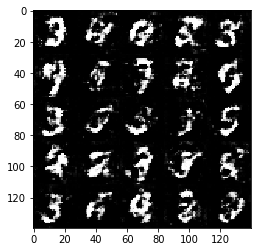

Epoch 2/2... Discriminator Loss: 0.4448... Generator Loss: 2.6923
Epoch 2/2... Discriminator Loss: 0.4765... Generator Loss: 1.8051
Epoch 2/2... Discriminator Loss: 0.4883... Generator Loss: 1.9250
Epoch 2/2... Discriminator Loss: 0.4955... Generator Loss: 2.5340
Epoch 2/2... Discriminator Loss: 0.2738... Generator Loss: 2.5822
Epoch 2/2... Discriminator Loss: 0.4362... Generator Loss: 1.8133
Epoch 2/2... Discriminator Loss: 0.3982... Generator Loss: 1.9048
Epoch 2/2... Discriminator Loss: 0.5840... Generator Loss: 1.4020
Epoch 2/2... Discriminator Loss: 0.6693... Generator Loss: 1.0366
Epoch 2/2... Discriminator Loss: 0.5147... Generator Loss: 1.3845


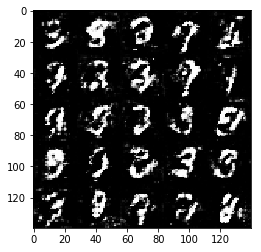

Epoch 2/2... Discriminator Loss: 0.6065... Generator Loss: 1.4862
Epoch 2/2... Discriminator Loss: 0.4438... Generator Loss: 2.0120
Epoch 2/2... Discriminator Loss: 0.4324... Generator Loss: 1.7561
Epoch 2/2... Discriminator Loss: 0.4903... Generator Loss: 3.3201
Epoch 2/2... Discriminator Loss: 0.4227... Generator Loss: 1.8596
Epoch 2/2... Discriminator Loss: 0.4735... Generator Loss: 1.9292
Epoch 2/2... Discriminator Loss: 0.6188... Generator Loss: 1.2096
Epoch 2/2... Discriminator Loss: 0.4664... Generator Loss: 2.1621
Epoch 2/2... Discriminator Loss: 0.4855... Generator Loss: 2.1917
Epoch 2/2... Discriminator Loss: 0.4812... Generator Loss: 1.5714


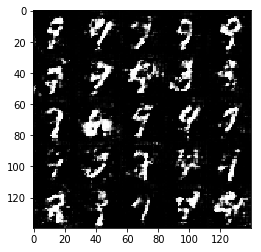

Epoch 2/2... Discriminator Loss: 0.4633... Generator Loss: 2.3112
Epoch 2/2... Discriminator Loss: 0.5268... Generator Loss: 1.6491
Epoch 2/2... Discriminator Loss: 0.4892... Generator Loss: 2.5538
Epoch 2/2... Discriminator Loss: 0.3636... Generator Loss: 2.1425
Epoch 2/2... Discriminator Loss: 0.9381... Generator Loss: 0.7491
Epoch 2/2... Discriminator Loss: 0.4334... Generator Loss: 2.1291
Epoch 2/2... Discriminator Loss: 0.4071... Generator Loss: 2.2250
Epoch 2/2... Discriminator Loss: 0.4948... Generator Loss: 1.9165
Epoch 2/2... Discriminator Loss: 0.3555... Generator Loss: 2.1830
Epoch 2/2... Discriminator Loss: 0.4498... Generator Loss: 2.4478


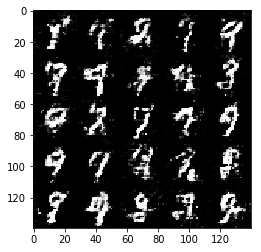

Epoch 2/2... Discriminator Loss: 0.3271... Generator Loss: 1.8963
Epoch 2/2... Discriminator Loss: 0.4348... Generator Loss: 2.0399
Epoch 2/2... Discriminator Loss: 0.3849... Generator Loss: 2.7360
Epoch 2/2... Discriminator Loss: 0.5125... Generator Loss: 1.9035
Epoch 2/2... Discriminator Loss: 0.3281... Generator Loss: 2.2156
Epoch 2/2... Discriminator Loss: 0.3927... Generator Loss: 2.0189
Epoch 2/2... Discriminator Loss: 0.3697... Generator Loss: 1.9489
Epoch 2/2... Discriminator Loss: 0.5045... Generator Loss: 1.4900
Epoch 2/2... Discriminator Loss: 0.5002... Generator Loss: 3.1107
Epoch 2/2... Discriminator Loss: 0.1842... Generator Loss: 3.3027


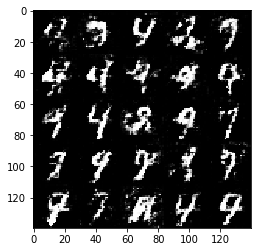

Epoch 2/2... Discriminator Loss: 0.2754... Generator Loss: 3.2092
Epoch 2/2... Discriminator Loss: 0.3459... Generator Loss: 2.2629
Epoch 2/2... Discriminator Loss: 0.5090... Generator Loss: 1.5311
Epoch 2/2... Discriminator Loss: 0.3138... Generator Loss: 2.1204
Epoch 2/2... Discriminator Loss: 0.3106... Generator Loss: 2.5112
Epoch 2/2... Discriminator Loss: 0.2976... Generator Loss: 2.9096
Epoch 2/2... Discriminator Loss: 0.4945... Generator Loss: 1.4897


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0006
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8306... Generator Loss: 0.6074
Epoch 1/1... Discriminator Loss: 0.6208... Generator Loss: 0.8749
Epoch 1/1... Discriminator Loss: 0.7560... Generator Loss: 2.0505
Epoch 1/1... Discriminator Loss: 0.8209... Generator Loss: 1.0993
Epoch 1/1... Discriminator Loss: 0.9329... Generator Loss: 1.3714
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 1.1520
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 1.3018
Epoch 1/1... Discriminator Loss: 1.3335... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.9087


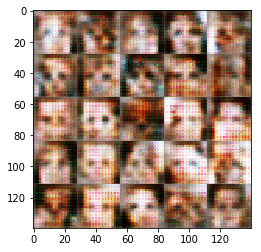

Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.7150... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.7966
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.8402


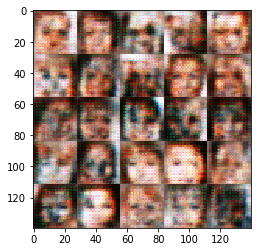

Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.6415
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.5358... Generator Loss: 0.5322
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.6692


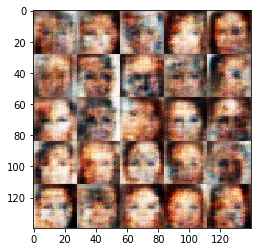

Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.7012
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.6927


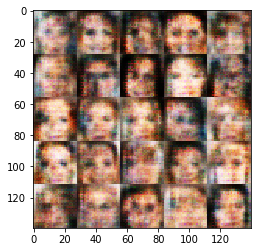

Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.7122


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0006
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.